In [1]:
import Orange
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wand.image import Image
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, \
    make_scorer, roc_curve

def load_pickle(path):
    print("Loading from:", path)
    with open(path, 'rb') as fh:
        return pickle.load(fh)

def save_pickle(obj, path):
    print("Saving to:", path)
    with open(path, 'wb') as fh:
        return pickle.dump(obj, fh)

warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 1337

## Read data

In [3]:
df = pd.read_pickle("data/chkp5_final.pkl")
print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27851 entries, 0 to 27850
Columns: 132 entries, views to trending
dtypes: float64(131), int64(1)
memory usage: 28.0 MB
None


,views,likes,dislikes,comment_count,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,...,category_id_Music,category_id_News & Politics,category_id_Nonprofits & Activism,category_id_People & Blogs,category_id_Pets & Animals,category_id_Science & Technology,category_id_Shows,category_id_Sports,category_id_Travel & Events,trending
0,-0.031703,-0.032604,0.052260,-0.028039,0.296296,0.181818,0.000000,-0.166667,0.333333,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.036468,-0.040810,-0.037469,-0.045419,-0.148148,-0.454545,0.166667,0.000000,-0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


<AxesSubplot:xlabel='count', ylabel='trending'>

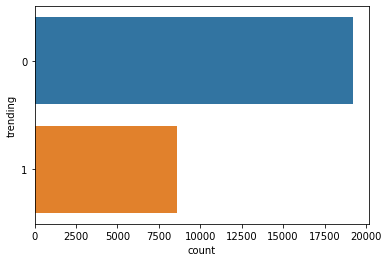

In [4]:
sns.countplot(data=df, y="trending")

## Indukcja reguł
Wykorzystany został algorytm *CN2* (Clark and Niblett; 1988) z biblioteki Orange. 

In [5]:
df_rules = Orange.data.Table("data/chkp5.csv")
df_rules

[[Entertainment, 3312536.0, 25422.0, 18133.0, 16934.0, ... | 0],
 [Nonprofits & Activism, 2116750.0, 24696.0, 1728.0, 2538.0, ... | 0],
 [Comedy, 23767254.0, 591025.0, 5089.0, 57607.0, ... | 0],
 [Music, 38469533.0, 569780.0, 3378.0, 20580.0, ... | 0],
 [Howto & Style, 1981522.0, 13517.0, 4649.0, 2321.0, ... | 0],
 ...
]

In [6]:
cn2_learner = Orange.classification.rules.CN2Learner()

cn2_learner.rule_finder.search_algorithm.beam_width = 10
cn2_learner.rule_finder.search_strategy.constrain_continuous = True # ograniczenie przestrzeni  dla wartości ciągłych
cn2_learner.rule_finder.general_validator.min_covered_examples = 100 # znalezione reguły muszą pokrywać conajmniej 100 przykładów
cn2_learner.rule_finder.general_validator.max_rule_length = 3 # znalezione reguły moą mieć maksymalnie 3 człony

# classifier = cn2_learner(df_rules)
# save_pickle(classifier, "data/chkp6/cn2.pkl")
classifier = load_pickle("data/chkp6/cn2.pkl")

Loading from: data/chkp6/cn2.pkl


In [7]:
trending = []
not_trending = []
for rule in classifier.rule_list:
    if rule.probabilities[0] > rule.probabilities[1]:
        not_trending.append((str(rule), np.sum(rule.covered_examples)))
    else:
        trending.append((str(rule), np.sum(rule.covered_examples)))

trending = sorted(trending, key=lambda tup: tup[1])[:10]
not_trending = sorted(not_trending, key=lambda tup: tup[1])[:10]

## Reguły dla trending

Posortowane według coverage

In [8]:
for i in trending:
    print(i[0])

IF description_url_ratio>=0.2535211267605634 AND comment_count>=1141.0 AND description_word_count>=13.0 THEN trending=1 
IF reactions_to_views_ratio>=0.06894651318705045 AND description_information_ratio>=0.7838899803536346 AND title_word_count>=6.0 THEN trending=1 
IF like_to_views_ratio>=0.04849814889156519 AND category_id==Entertainment AND publish_time_month<=3.0 THEN trending=1 
IF like_to_views_ratio<=0.001972817615788336 AND median_red<=189.0 AND title_letter_count<=56.0 THEN trending=1 
IF publish_time_year>=2018.0 AND description_len<=171.0 AND description_letter_count>=104.0 THEN trending=1 
IF title_information_ratio<=0.6811594202898551 AND dislike_to_views_ratio>=0.0005470199305522523 AND views>=37098.0 THEN trending=1 
IF publish_time_year>=2018.0 AND iqr_blue>=51.0 AND shouting_ratio_title<=0.24324324324324326 THEN trending=1 
IF like_to_views_ratio>=0.0695906659342613 AND category_id!=People & Blogs AND shouting_ratio_title>=0.15384615384615385 THEN trending=1 
IF publis

## Reguły dla nie trending

In [9]:
for i in not_trending:
    print(i[0])

IF dislike_to_views_ratio<=0.00025817555938037863 AND has_music!=0 AND dislikes>=133.0 THEN trending=0 
IF dislike_to_views_ratio<=0.00020895010271547156 AND count_happy>=1.0 AND shouting_ratio_description>=0.11428571428571428 THEN trending=0 
IF dislike_to_views_ratio<=0.00048062385613113713 AND has_vlog!=0 AND dislike_to_reactions_ratio>=0.007604930092611762 THEN trending=0 
IF dislike_to_views_ratio<=0.00029601291708846063 AND shouting_ratio_description>=0.1941747572815534 AND description_punctuation_count>=2.0 THEN trending=0 
IF comment_count<=41.0 AND description_information_ratio<=0.7568807339449541 AND like_to_reactions_ratio>=0.9584877687175686 THEN trending=0 
IF category_id==Education AND like_to_views_ratio<=0.028763051614857787 AND dislike_to_views_ratio<=0.000707818444568968 THEN trending=0 
IF reactions<=1933.0 AND shouting_ratio_channel_title<=0.11538461538461539 AND publish_time_month<=9.0 THEN trending=0 
IF has_game!=0 AND description_len>=451.0 AND description_url_r

## Train, Validation, Test Split

In [10]:
X, y = df.drop('trending',1), df['trending']

In [11]:
# 0.2 - test, 0.2 - val, 0.8 - train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=RANDOM_STATE)

In [12]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.691023
1    0.308977
Name: trending, dtype: float64
0    0.691023
1    0.308977
Name: trending, dtype: float64
0    0.691079
1    0.308921
Name: trending, dtype: float64


## Training

In [13]:
algo = [
    ('lr', LogisticRegression(random_state=RANDOM_STATE)),
    # ('lightgbm', )
        ]
# Define hyperparameter searches
hprams = [
    # LR
    {
        'tol': np.linspace(1e-5, 1e-2, num=5),
        'C': np.linspace(0.5, 5, num=10),
        'class_weight': [None, 'balanced'],
        'max_iter': np.linspace(20, 500, num=13)
    },
]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

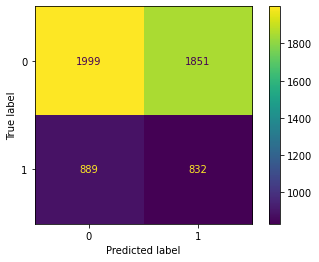

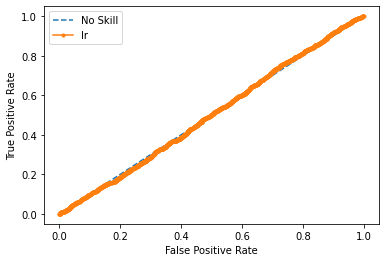

Saving to: data/chkp6/rscv_lr.pkl


In [35]:
df_results = pd.DataFrame(columns=[
    'algorithm',
    'best_params',
    'algorithm_path',
    'val_accuracy',
    'val_balanced_accuracy',
    'val_roc_auc',
    'val_gmean',
    'test_accuracy',
    'test_balanced_accuracy',
    'test_roc_auc',
    'test_gmean',
    'cm_path',
    'roc_path'
])

for (a_name, a), h in tqdm(zip(algo, hprams), total=len(algo)):
    clf = RandomizedSearchCV(a, h,
            scoring={
                'accuracy': make_scorer(accuracy_score),
                'bacc': make_scorer(balanced_accuracy_score),
                'auroc': make_scorer(roc_auc_score),
                'gmean': make_scorer(geometric_mean_score)},
            refit='gmean',
            random_state=RANDOM_STATE)
    # Train
    clf.fit(X_train, y_train)
    # Threshold setup - validation data to estimate threshold
    fpr, tpr, thresholds = roc_curve(y_val, clf.predict_proba(X_val)[:, 1])
    gmeans = np.sqrt(tpr * (1-fpr))
    THRESHOLD = 0.5#thresholds[np.argmax(gmeans)]
    # applying to test data
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    y_pred = np.where(y_pred_prob > THRESHOLD, 1, 0)
    # Calculating confusion matrix
    cm_path = f'data/chkp6/cm_{a_name}.pdf'
    cm = confusion_matrix(y_test, y_pred)
    f1 = plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
    disp.plot()
    f1.savefig(cm_path, bbox_inches='tight')
    # Calculating ROC
    roc_path = f'data/chkp6/roc_{a_name}.pdf'
    f = plt.figure()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=a_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    f.savefig(roc_path, bbox_inches='tight')
    # Save RandomSearch results
    algo_path = f'data/chkp6/rscv_{a_name}.pkl'
    save_pickle(clf, algo_path)
    # Predictions
    y_pred_prob_val = clf.predict_proba(X_val)[:, 1]
    y_pred_val = np.where(y_pred_prob_val > THRESHOLD, 1, 0)
    y_pred_prob_test = clf.predict_proba(X_test)[:, 1]
    y_pred_test = np.where(y_pred_prob_test > THRESHOLD, 1, 0)
    # Appending results
    df_results = pd.concat([
        df_results,
        pd.DataFrame([[
            a_name,
            clf.best_params_,
            algo_path,
            accuracy_score(y_val, y_pred_val),
            balanced_accuracy_score(y_val, y_pred_val),
            roc_auc_score(y_val, y_pred_prob_val),
            geometric_mean_score(y_val, y_pred_val),
            accuracy_score(y_test, y_pred_test),
            balanced_accuracy_score(y_test, y_pred_test),
            roc_auc_score(y_test, y_pred_prob_test),
            geometric_mean_score(y_test, y_pred_test),
            cm_path, roc_path
        ]], columns=df_results.columns)
    ], ignore_index=True)

In [34]:
df_results

,algorithm,best_params,algorithm_path,val_accuracy,val_balanced_accuracy,val_roc_auc,val_gmean,test_accuracy,test_balanced_accuracy,test_roc_auc,test_gmean,cm_path,roc_path
0,lr,"{'tol': 0.0025075, 'max_iter': 180.0, 'class_w...",data/chkp6/rscv_lr.pkl,0.480251,0.497838,0.492671,0.495705,0.486807,0.500817,0.501503,0.499473,data/chkp6/cm_lr.pdf,data/chkp6/roc_lr.pdf


In [32]:
# Reading plots example
auroc_path = df_results['roc_path'].values[0]

from IPython.display import IFrame
IFrame(auroc_path, width=600, height=300)